Код, позволяющий подключиться ноутбуку к вашему гугл диску

In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


Импорты библиотек

In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import tensorflow as tf
from PIL import Image
import scipy
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, LSTM, Concatenate
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Reshape
import re

Вспомогательные функции, потребуются для работы с картинками

In [3]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_crop_padded(im, w, h, pad):
    list_patches = []
    
    imgwidth = im.shape[0] - pad
    imgheight = im.shape[1] - pad
    
    is_2d = len(im.shape) < 3
    for i in range(pad,imgheight,h):
        for j in range(pad,imgwidth,w):
            if is_2d:
                im_patch = im[j-pad:j+w+pad, i-pad:i+h+pad]
            else:
                im_patch = im[j-pad:j+w+pad, i-pad:i+h+pad, :]
            list_patches.append(im_patch)
    return list_patches

def deflatten(img_flat, patch_size):
    img = []
    for i in range(len(img_flat)):
        img.append(img_flat[i].reshape((patch_size,patch_size)))
    return img


# Function to ransform patches into a complete black and white image
def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

def img_crop_output(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h].flatten() # Here we add the flatten function
            else:
                im_patch = im[j:j+w, i:i+h, :].flatten() # Here we add the flatten function
            list_patches.append(im_patch)
    return list_patches


def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

foreground_threshold = 0.25

def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))


Начало работы скрипта: загружаем картинки и маски

In [4]:
# image
image_dir = "/content/MyDrive/MyDrive/data/training/images/"
files = os.listdir(image_dir)
n = 100
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

pad = 4
print("Loading " + str(n) + " images_padded")
imgs_padded = [np.pad(load_image(image_dir + files[i]), ((pad,pad),(pad,pad),(0,0)), 'constant') for i in range(n)]
print(files[0])

# groundtruth
gt_dir = "/content/MyDrive/MyDrive/data/training/groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_095.png
Loading 100 images_padded
satImage_095.png
Loading 100 images
satImage_095.png


Пример загруженной картинки и ее маски

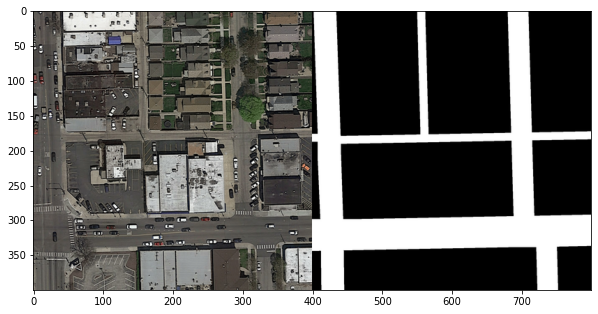

In [ ]:
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

Преобразование картинки в массив из "патчей", 16х16 пикселей

In [5]:
patch_size = 16
n = 100
img_patches = [img_crop_padded(imgs_padded[i], patch_size, patch_size, pad) for i in range(n)]
gt_patches = [img_crop_output(gt_imgs[i], patch_size, patch_size) for i in range(n)]
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

print('Size patch image', img_patches.shape)
print('Size patch groundtruth', gt_patches.shape)

X_train = img_patches
Y_train = gt_patches

Size patch image (62500, 24, 24, 3)
Size patch groundtruth (62500, 256)


Первая ветвь нейронки

In [60]:
model_cnn = Sequential()
model_cnn.add(Convolution2D(32, 3, 3, activation='relu', padding='same', input_shape=(24, 24, 3)))
model_cnn.add(Convolution2D(32, 3, 3, activation='relu', padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_cnn.add(Dropout(0.25)) 

model_cnn.add(Convolution2D(64, 3, 3, activation='relu', padding='same'))
model_cnn.add(Convolution2D(64, 3, 3, activation='relu', padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_cnn.add(Dropout(0.25))

model_cnn.add(Convolution2D(128, 3, 3, activation='relu', padding='same'))
model_cnn.add(Convolution2D(128, 3, 3, activation='relu', padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_cnn.add(Dropout(0.25))

model_cnn.add(Flatten())
model_cnn.add(Dense(1024, activation='relu'))
model_cnn.add(Dropout(0.5))

Соединяем две ветви нейронки в одну, получаем результирующую модель нейронной сети

In [79]:
model_cnn2 = Sequential()
model_cnn2.add(Convolution2D(32, 3, 3, activation='relu', padding='same', input_shape=(24, 24, 3)))
model_cnn2.add(Convolution2D(32, 3, 3, activation='relu', padding='same'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_cnn2.add(Dropout(0.25)) 

model_cnn2.add(Convolution2D(64, 3, 3, activation='relu', padding='same'))
model_cnn2.add(Convolution2D(64, 3, 3, activation='relu', padding='same'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_cnn2.add(Dropout(0.25))

model_cnn2.add(Flatten())
model_cnn2.add(Dense(1024, activation='relu'))
model_cnn2.add(Dropout(0.5))

Настройки компиляции модели. Запускаем тренировку на тренировчных данных

In [ ]:
from keras.layers.merge import concatenate, average
from keras.models import Model, Sequential
from keras.layers import Dense, Input

merged = average([model_cnn2.output,model_cnn.output])
output = Dense(256, activation='sigmoid')(merged)
model_final = Model([model_cnn2.inputs, model_cnn.inputs], output)
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model_final.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

model_final.fit([X_train, X_train], y=Y_train, batch_size=8, epochs=200, verbose=2, validation_split=0.1, shuffle=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
7032/7032 - 40s - loss: 0.0850 - accuracy: 0.0104 - val_loss: 0.0830 - val_accuracy: 0.0013
Epoch 2/200
7032/7032 - 37s - loss: 0.0823 - accuracy: 0.0166 - val_loss: 0.0780 - val_accuracy: 0.0270
Epoch 3/200
7032/7032 - 37s - loss: 0.0804 - accuracy: 0.0341 - val_loss: 0.0787 - val_accuracy: 0.2866
Epoch 4/200
7032/7032 - 37s - loss: 0.0835 - accuracy: 0.0365 - val_loss: 0.0888 - val_accuracy: 0.0051
Epoch 5/200


Понравилось? Сохраняем веса в корень гугл диска

In [129]:
model_final.save("/content/MyDrive/MyDrive/modelRoads3")

INFO:tensorflow:Assets written to: /content/MyDrive/MyDrive/modelRoads3/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: /content/MyDrive/MyDrive/modelRoads3/assets


Загрузка готовой модели

In [134]:
from keras.models import load_model
del model_final
model_final = load_model("/content/MyDrive/MyDrive/modelRoads3")

Ну и соответственно просмотр изображения с маской

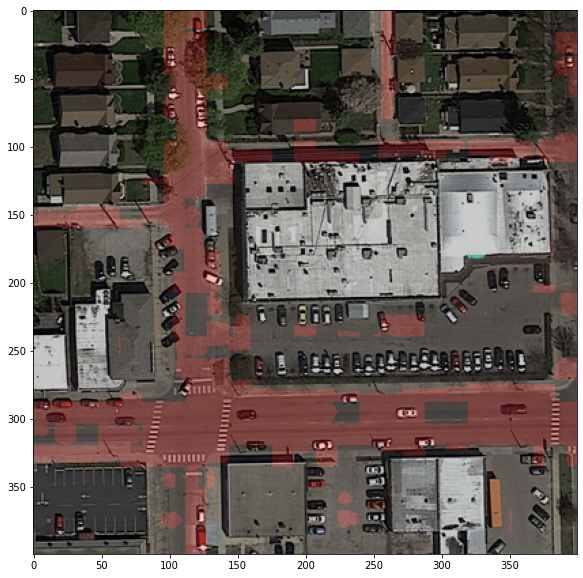

In [135]:
img_idx = 4 #Выберите число от 1 до 50, чтобы посмотреть предсказанные маски на других тестовых картинках
X_test = np.asarray(img_crop_padded(imgs_padded[img_idx], patch_size, patch_size, pad))
prediction = model_final.predict([X_test,X_test], batch_size=32)
pred = np.array(prediction)
predict_binary = np.where(prediction > 0.5, 1, 0)
im_test = deflatten(predict_binary, patch_size)
im_non_flat = np.asarray(im_test)
w = imgs[img_idx].shape[0]
h = imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, im_non_flat)
new_img = make_img_overlay(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(new_img)